In [1]:
using Distributions
using Memoization
using StatsBase
using StatsPlots
default(fmt=:png, titlefontsize=10, tickfontsize=6, size=(400, 250),
    plot_titlefontsize=10, guidefontsize=9)
safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

safediv (generic function with 1 method)

In [2]:
riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat(a, b, c, d)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m-1) + safediv(q̂*(1-q̂), n-1))
end

@memoize function pvalue_rd_wald(a, b, c, d; Δ=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat))
end

function confint_rd_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    [RDhat - z*SEhat_riskdiffhat, RDhat + z*SEhat_riskdiffhat]
end

confint_rd_wald (generic function with 1 method)

Guangyong Zou and Allan Donner,<br>
A simple alternative confidence interval for the difference between two proportions,<br>
Controlled Clinical Trials, Volume 25, Issue 1, February 2004, Pages 3-12,<br>
https://doi.org/10.1016/j.cct.2003.08.010

In [3]:
@memoize function pvalue_rd_zou_donner(a, b, c, d; Δ=0)
    ((a==0 && d==0) || (b==0 && c==0)) && return 1.0
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    Z = safediv((1 - RDhat^2)*abs(atanh(RDhat) - atanh(Δ)), SEhat_riskdiffhat)
    2ccdf(Normal(), abs(Z))
end

function confint_rd_zou_donner(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    m = atanh(RDhat)
    d = safediv(2z*SEhat_riskdiffhat, 1 - RDhat^2)
    [tanh(m-d), tanh(m+d)]
end

confint_rd_zou_donner (generic function with 1 method)

https://twitter.com/heijikodera/status/1548616745518497792

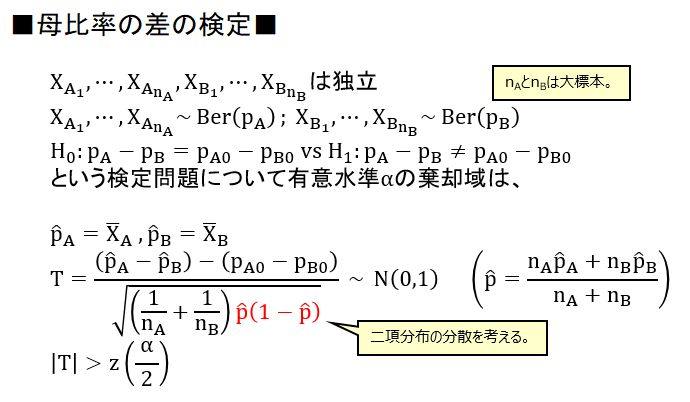

https://twitter.com/heijikodera/status/1549368016269639682

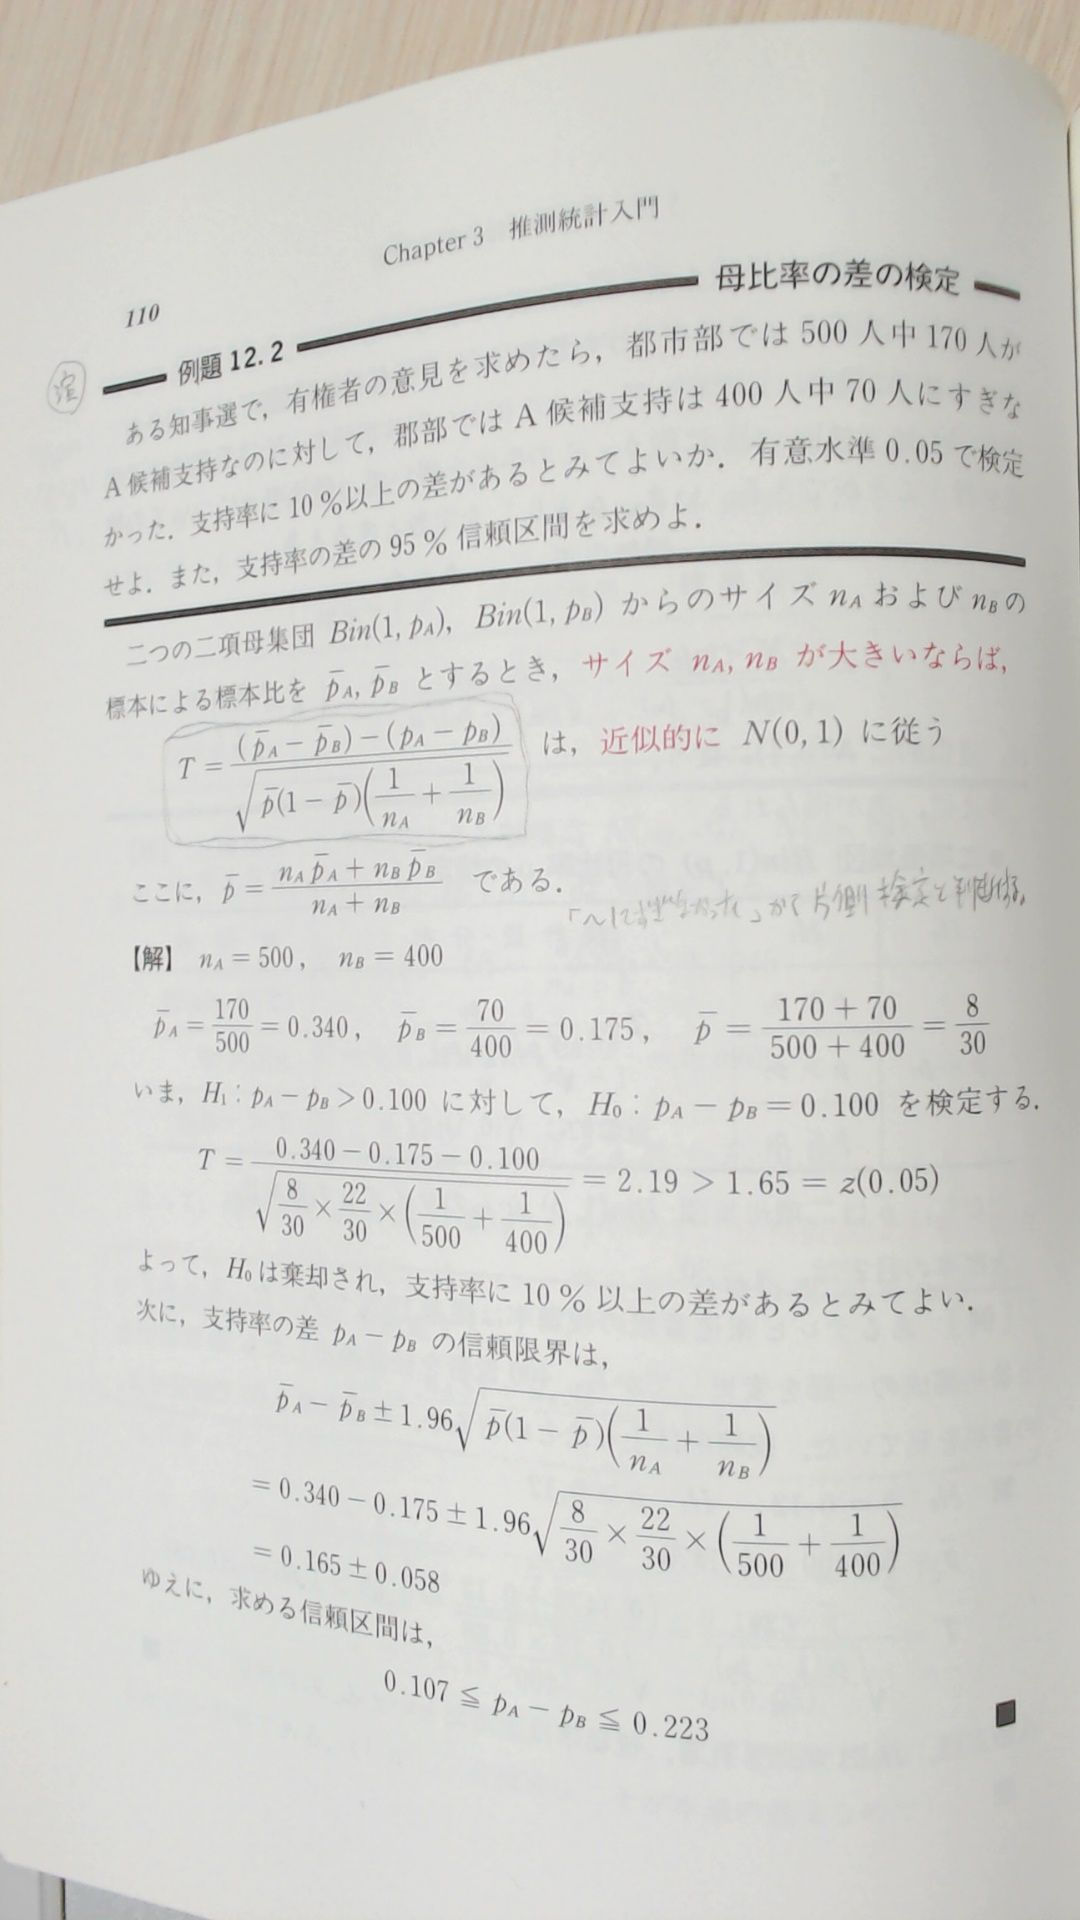

小寺平治, 新統計入門, 裳華房, 1996/10/20

In [4]:
riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat_heijikodera(a, b, c, d)
    m, n = a+b, c+d
    p̂ = (a + c) / (m + n)
    √((1/m + 1/n) * p̂*(1 - p̂))
end

@memoize function pvalue_rd_heijikodera(a, b, c, d; Δ=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat_heijikodera = stderr_riskdiffhat_heijikodera(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat_heijikodera))
end

pvalue_rd_heijikodera (generic function with 1 method)

In [5]:
a, b, c, d = 90, 10, 10, 90

function plot_pvaluefuncs(a, b, c, d; Δ=0.0, xlim=(-1.0, 1.0), kwargs...)
    @show Δ
    @show pvalue_rd_zou_donner(a, b, c, d; Δ)
    @show pvalue_rd_wald(a, b, c, d; Δ)
    @show pvalue_rd_heijikodera(a, b, c, d; Δ)

    plot(legend=:topleft)
    plot!(Δ -> pvalue_rd_zou_donner(a, b, c, d; Δ), xlim...; label="Zou-Donner")
    plot!(Δ -> pvalue_rd_wald(a, b, c, d; Δ); label="Wald", ls=:dash)
    plot!(Δ -> pvalue_rd_heijikodera(a, b, c, d; Δ); label="heijikodera", ls=:dashdot)
    plot!(ytick=0:0.1:1)
    plot!(xguide="p − q", yguide="P-value")
    title!("a, b, c, d = $a, $b, $c, $d")
    plot!(; kwargs...)
end

plot_pvaluefuncs (generic function with 1 method)

Δ = 0.1
pvalue_rd_zou_donner(a, b, c, d; Δ) = 0.02381443283660613
pvalue_rd_wald(a, b, c, d; Δ) = 0.02250722989470368
pvalue_rd_heijikodera(a, b, c, d; Δ) = 0.028440971813599288


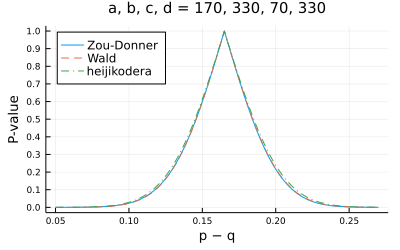

In [6]:
plot_pvaluefuncs(170, 500-170, 70, 400-70; Δ=0.1, xlim=(0.05, 0.27))

Δ = -0.1
pvalue_rd_zou_donner(a, b, c, d; Δ) = 0.1579960502023757
pvalue_rd_wald(a, b, c, d; Δ) = 0.15939040677403396
pvalue_rd_heijikodera(a, b, c, d; Δ) = 0.15729920705028505


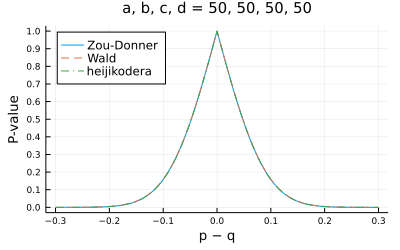

In [7]:
plot_pvaluefuncs(50, 50, 50, 50; Δ=-0.1, xlim=(-0.3, 0.3))

Δ = 0.1
pvalue_rd_zou_donner(a, b, c, d; Δ) = 0.15802499932298042
pvalue_rd_wald(a, b, c, d; Δ) = 0.15096231976025218
pvalue_rd_heijikodera(a, b, c, d; Δ) = 0.15729920705028533


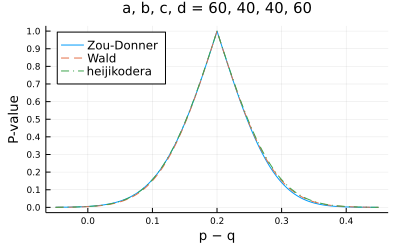

In [8]:
plot_pvaluefuncs(60, 40, 40, 60; Δ=0.1, xlim=(-0.05, 0.45))

Δ = 0.5
pvalue_rd_zou_donner(a, b, c, d; Δ) = 0.10511640118769819
pvalue_rd_wald(a, b, c, d; Δ) = 0.12471041265268383
pvalue_rd_heijikodera(a, b, c, d; Δ) = 0.15729920705028494


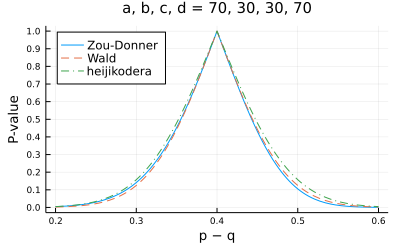

In [9]:
plot_pvaluefuncs(70, 30, 30, 70; Δ=0.5, xlim=(0.2, 0.6))

Δ = 0.5
pvalue_rd_zou_donner(a, b, c, d; Δ) = 0.1054003165989034
pvalue_rd_wald(a, b, c, d; Δ) = 0.0785934912071021
pvalue_rd_heijikodera(a, b, c, d; Δ) = 0.15729920705028477


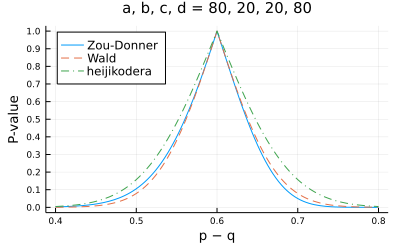

In [10]:
plot_pvaluefuncs(80, 20, 20, 80; Δ=0.5, xlim=(0.4, 0.8))

Δ = 0.7
pvalue_rd_zou_donner(a, b, c, d; Δ) = 0.050830617004284304
pvalue_rd_wald(a, b, c, d; Δ) = 0.019016473672300433
pvalue_rd_heijikodera(a, b, c, d; Δ) = 0.15729920705028477


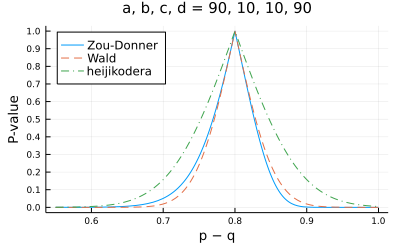

In [11]:
plot_pvaluefuncs(90, 10, 10, 90; Δ=0.7, xlim=(0.55, 1.0))

Δ = 0.77
pvalue_rd_zou_donner(a, b, c, d; Δ) = 0.03576898945571617
pvalue_rd_wald(a, b, c, d; Δ) = 0.02542065354368565
pvalue_rd_heijikodera(a, b, c, d; Δ) = 0.17971249487899946


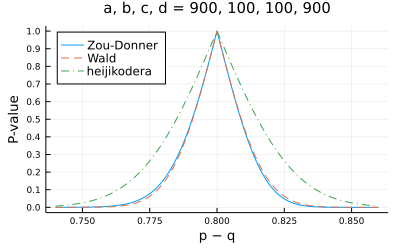

In [12]:
plot_pvaluefuncs(900, 100, 100, 900; Δ=0.77, xlim=(0.74, 0.86))

In [13]:
function sim(m, p, n, q; L=10^5)
    Δ = p - q
    bin1, bin2 = Binomial(m, p), Binomial(n, q)
    z_wald = similar(zeros(), L)
    z_zou_donner = similar(zeros(), L)
    z_heijikodera = similar(zeros(), L)
    Threads.@threads for i in 1:L
        a, c = rand(bin1), rand(bin2)
        b, d = m-a, n-c
        RDhat = riskdiffhat(a, b, c, d)
        SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
        SEhat_riskdiffhat_heijikodera = stderr_riskdiffhat_heijikodera(a, b, c, d)
        z_wald[i] = safediv(RDhat - Δ, SEhat_riskdiffhat)
        z_zou_donner[i] = safediv((1 - RDhat^2)*(atanh(RDhat) - atanh(Δ)), SEhat_riskdiffhat)
        z_heijikodera[i] = safediv(RDhat - Δ, SEhat_riskdiffhat_heijikodera)
    end
    z_wald, z_zou_donner, z_heijikodera
end

function plot_sim(m, p, n, q; L=10^5, bin=range(-5, 5, 30), kwargs...)
    z_wald, z_zou_donner, z_heijikodera = sim(m, p, n, q; L)
    norm = true
    stephist(z_wald; norm, bin, label="Wald")
    stephist!(z_zou_donner; norm, bin, label="Zou-Donner", ls=:dash)
    stephist!(z_heijikodera; norm, bin, label="Kodera", ls=:dashdot)
    plot!(Normal(0,1); label="Normal(0,1)")
    plot!(xguide="z")
    plot!(size=(500, 300))
    plot!(; kwargs...)
end

plot_sim (generic function with 1 method)

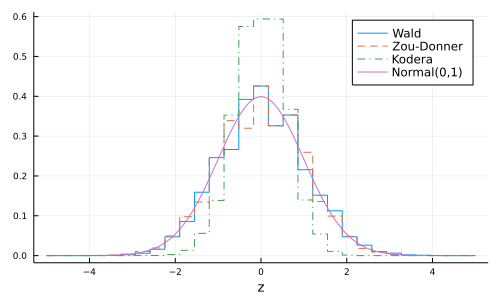

In [14]:
plot_sim(1000, 0.9, 1000, 0.1)

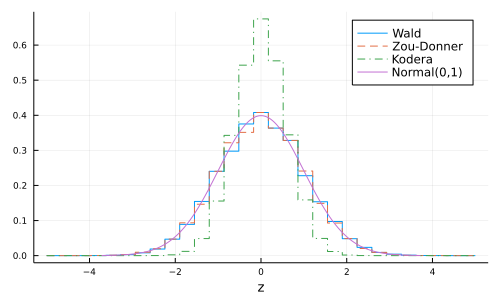

In [15]:
plot_sim(10000, 0.9, 10000, 0.1)

In [16]:
function E(f, m, p, n, q)
    bin1, bin2 = Binomial(m, p), Binomial(n, q)
    sum(f(a, m-a, c, n-c) * pdf(bin1, a) * pdf(bin2, c)
        for a in support(bin1) for c in support(bin2))
end

@memoize function probalphaerror(pvaluefunc, m, p, n, q; Δ=p-q, α=0.05)
    E(m, p, n, q) do a, b, c, d
        pvaluefunc(a, b, c, d; Δ) < α
    end
end

probalphaerror (generic function with 1 method)

In [17]:
@show probalphaerror(pvalue_rd_zou_donner, 10, 0.8, 10, 0.2)
@show probalphaerror(pvalue_rd_wald, 10, 0.8, 10, 0.2)
@show probalphaerror(pvalue_rd_heijikodera, 10, 0.8, 10, 0.2);

probalphaerror(pvalue_rd_zou_donner, 10, 0.8, 10, 0.2) = 0.03231154806689111
probalphaerror(pvalue_rd_wald, 10, 0.8, 10, 0.2) = 0.0797640070156676
probalphaerror(pvalue_rd_heijikodera, 10, 0.8, 10, 0.2) = 0.010419831753230276


In [18]:
function plot_probalphaerrors(m, p, n, q)
#     P = plot(legend=:topleft)
#     plot!(α -> probalphaerror(pvalue_rd_zou_donner, m, p, n, q; α), 0, 1;
#         label="Zou-Donner")
#     plot!(α -> probalphaerror(pvalue_rd_wald, m, p, n, q; α), 0, 1;
#         label="Wald", ls=:dash)
#     plot!(α -> probalphaerror(pvalue_rd_heijikodera, m, p, n, q; α), 0, 1;
#         label="heijikodera", ls=:dashdot)
#     plot!([0, 1], [0, 1]; label="", c=:black, ls=:dot)
#     plot!(xtick=0:0.1:1, ytick=0:0.1:1)
#     plot!(xlim=(-0.02, 1.02), ylim=(-0.02, 1.02))
#     title!("m, p = $m, $p,  n, q = $n, $q")
    
    Q = plot(legend=:topleft)
    plot!(α -> probalphaerror(pvalue_rd_zou_donner, m, p, n, q; α), 0, 0.1;
        label="Zou-Donner")
    plot!(α -> probalphaerror(pvalue_rd_wald, m, p, n, q; α), 0, 0.1;
        label="Wald", ls=:dash)
    plot!(α -> probalphaerror(pvalue_rd_heijikodera, m, p, n, q; α), 0, 0.1;
        label="heijikodera", ls=:dashdot)
    plot!([0, 0.1], [0, 0.1]; label="", c=:black, ls=:dot)
    plot!(xtick=0:0.01:1, ytick=0:0.01:1)
    plot!(xlim=(-0.002, 0.102), ylim=(-0.002, 0.102))
    title!("m, p = $m, $p,  n, q = $n, $q")
    plot!(size=(350, 350))
    plot!(xguide="nominal significance level α", yguide="probability of alpha error")
    
#     plot(P, Q; size=(600, 300))
end

plot_probalphaerrors (generic function with 1 method)

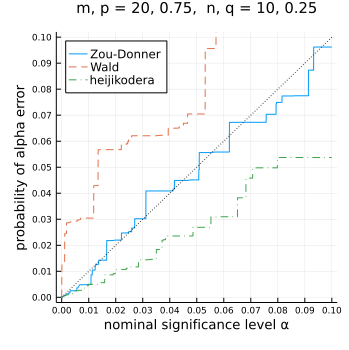

In [19]:
plot_probalphaerrors(20, 0.75, 10, 0.25)

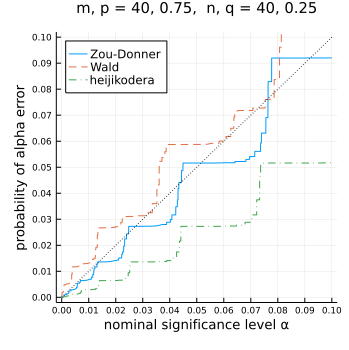

In [20]:
plot_probalphaerrors(40, 0.75, 40, 0.25)

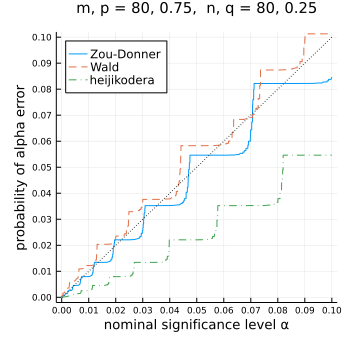

In [21]:
plot_probalphaerrors(80, 0.75, 80, 0.25)

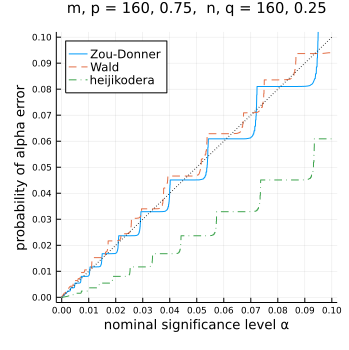

In [22]:
plot_probalphaerrors(160, 0.75, 160, 0.25)

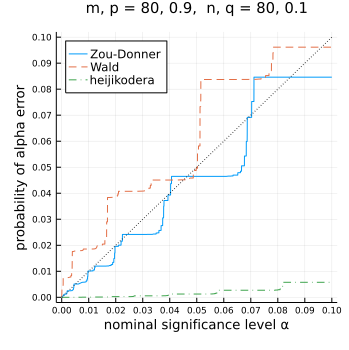

In [23]:
plot_probalphaerrors(80, 0.9, 80, 0.1)

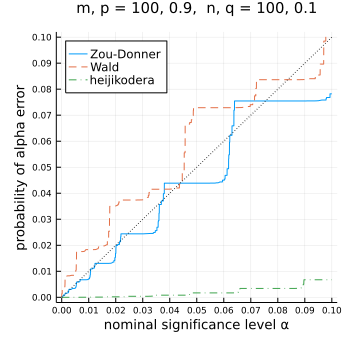

In [24]:
plot_probalphaerrors(100, 0.9, 100, 0.1)

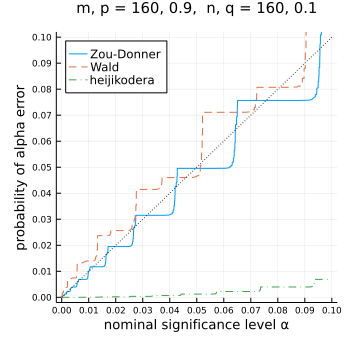

In [25]:
plot_probalphaerrors(160, 0.9, 160, 0.1)